In [1]:
import requests
import urllib
from itertools import combinations
import time
import numpy as np
import pandas as pd
import scipy as sp
from scipy import spatial
import vk
import networkx as nx
from pymongo import MongoClient
import random
from tqdm.notebook import tqdm
# import igraph
# from community import best_partition  #modularity, 
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline

/home/user/msTest/venv_jupyterhab/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [15]:
!pip freeze | grep network

networkx==2.3


In [6]:
mongoItemsClient = MongoClient("mongodb://192.168.135.21:27017/");
mongoItemsDatabaseClient = mongoItemsClient["HSE_VK_STUDENTS"];
users_collection = mongoItemsDatabaseClient["Users"];

In [7]:
#url = "https://dl.dropboxusercontent.com/s/cpthb2lv1ctcei0/range_1_ids.tsv?dl=1"
#with urllib.request.urlopen(url) as f:
#    data = f.read().decode('utf-8')
#with open('range_1_ids.tsv', 'w') as f:
#    f.write(data) 

ids = ["VK_54264783", "VK_136484266", "VK_247834045", "VK_134710608", "VK_135708179", "VK_536989147", "VK_72990108", "VK_26064791", "VK_166144488"]


In [8]:
cursor = users_collection.aggregate([
    {"$match":
        {
        "ID": {"$in":ids}
        }
    },
    { "$project": 
        { 
            "ID" : 1,
            "Friends" : 1,
            "Name": {"$concat": [ "$FirstName", " ", "$LastName"]},
        } 
    },
    {"$unwind":"$Friends"}
    ])
df_2370 =  pd.DataFrame(list(cursor))
print(len(df_2370))


2370


In [16]:
df_2370.head()

,ID,Friends,Name
103,VK_10032792,VK_178686202,Андрей Жупиков
108,VK_10032792,VK_188335979,Андрей Жупиков
116,VK_10032792,VK_247834045,Андрей Жупиков
129,VK_100570406,VK_8211,Анна Кученкова
130,VK_100570406,VK_121507,Анна Кученкова


In [9]:
friends = list(df_2370["Friends"].unique())
ids = list(df_2370["ID"].unique())
print(len(friends))
with open("friends_list.txt", "w") as fp:
    fp.writelines(friends)

2267


In [10]:
cursor = users_collection.aggregate([
    {"$match":
        {
        "ID": {"$in":friends}
        }
    },
    { "$project": 
        { 
            "ID" : 1,
            "Friends" : 1,
            "Name": {"$concat": [ "$FirstName", " ", "$LastName"]},
        } 
    },
    {"$unwind":"$Friends"}
    ])
df_2370 =  pd.DataFrame(list(cursor))
print(len(df_2370))


1200368


In [11]:
df_2370 = df_2370[df_2370["Friends"].isin(friends)]
del df_2370["_id"]
df_2370.to_csv('vk.tsv',sep = '\t')
print(len(df_2370))

31755


In [12]:
G_small = nx.Graph()
count = 0

node_set = set()
pbar = tqdm(total=len(df_2370), desc='nodes')
for index, row in df_2370.iterrows():
    if row["ID"] not in G_small.nodes():
        G_small.add_node(row["ID"], attr_dict = {'Name':row["Name"]})
    pbar.update(1)
    
pbar = tqdm(total=len(df_2370), desc='edges')
for index, row in df_2370.iterrows():
    if (row["ID"], row["Friends"]) not in G_small.edges() and (row["Friends"], row["ID"]) not in G_small.edges():
        G_small.add_edge(row["ID"], row["Friends"])    
    pbar.update(1)

In [13]:
print("Number of nodes -", len(G_small.nodes()))
print("Number of edges -", len(G_small.edges()))

Number of nodes - 2267
Number of edges - 19353


In [5]:
largest_component = max(nx.connected_components(G_small), key=len)
G2 = G_small.subgraph(largest_component)
print("Diameter of connected component -", nx.diameter(G2))
print("Average clustering coefficient - {:.2f}".format(nx.average_clustering(G2)), "\n")

Diameter of connected component - 6
Average clustering coefficient - 0.56 



In [17]:
for cc in sorted(nx.connected_components(G_small), key = len, reverse=True):
    print("Diameter of connected component -", nx.diameter( G_small.subgraph(cc)))
    print("Average clustering coefficient - {:.2f}".format(nx.average_clustering(G_small.subgraph(cc))), "\n")

Diameter of connected component - 4
Average clustering coefficient - 0.52 



In [ ]:
fh=open("vk.adjlist",'wb')
nx.write_adjlist(G2, fh)
## write the graph and the next time just open it:
#nx.write_gexf(G_small, "vk_small_network.gexf")
## open the graph and set appropriate layout for better visualization:
#G = nx.read_gexf('vk_small_network.gexf')

In [3]:
url = "https://dl.dropboxusercontent.com/s/q9geru5vtmz5b55/vk.adjlist?dl=1"
with urllib.request.urlopen(url) as f:
    data = f.read().decode('utf-8')
with open('vk.adjlist', 'w') as f:
    f.write(data) 
    
G = nx.read_adjlist('vk.adjlist')

G_small = nx.read_adjlist('vk.adjlist')
print("Number of nodes -", len(G_small.nodes()))
print("Number of edges -", len(G_small.edges()))

Number of nodes - 2113
Number of edges - 25737


In [95]:
coord = nx.spring_layout(G_small, k = 0.15)

/home/user/msTest/venv_jupyterhab/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


(-0.95, 1.05, -1.0, 0.75)

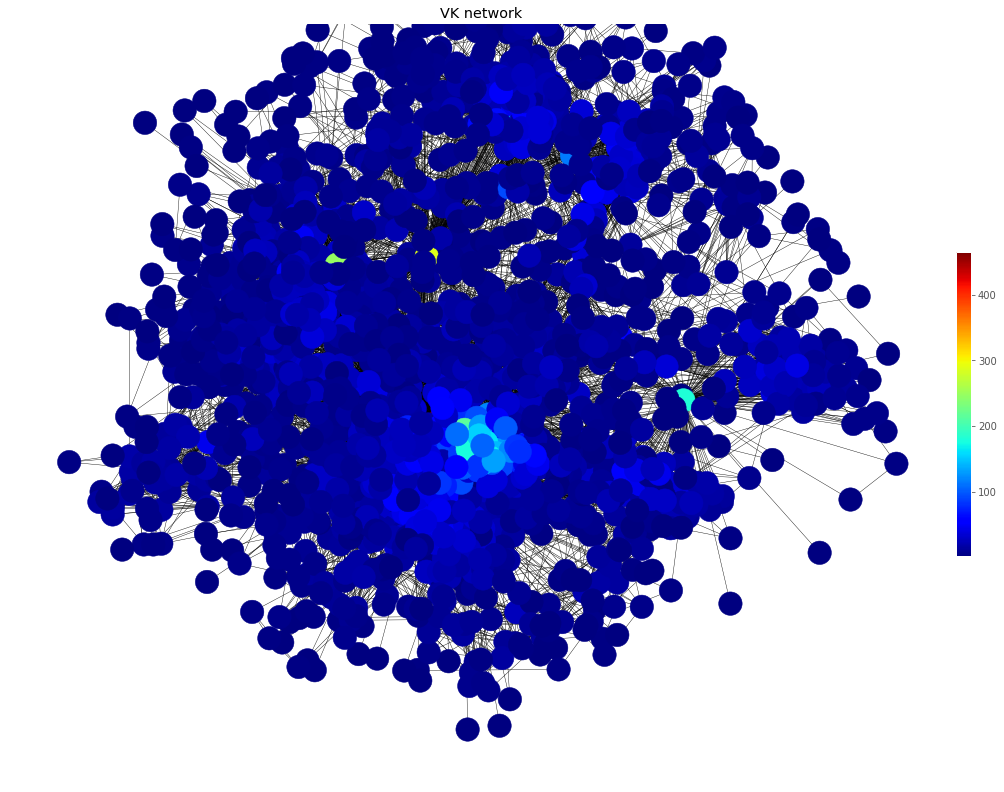

In [96]:
plt.figure(figsize=(20,14))
# k = nx.degree(G_small)
k = dict (G_small.degree ())
# print(k)
# set nodes' colors according to their degrees:
node_colors = list(k.values())

nodes = nx.draw_networkx_nodes(G_small, pos = coord, 
                               node_color=node_colors, 
                               node_size = 550, 
                               nodelist=list(k.keys()),                
                               with_labels = False,
                               cmap = 'jet')
edges = nx.draw_networkx_edges(G_small, pos = coord, width = .4)

# the borders can be then reduced to zoom in the graph:
plt.xlim([-.95, 1.05])
plt.ylim([-1., .75])
# add colorbar to see which nodes have the highest degrees:
plt.colorbar(nodes, shrink = .4, pad = .0005, aspect = 20)
plt.title('VK network')
plt.axis("off")

In [97]:
# function to create proper histogram in matplotlib:
def plot_hist(data, colormap, alpha, bins = 10, round_value = 1):
    cm = plt.cm.get_cmap(colormap)
    counts, bins, patches = plt.hist(data, alpha = alpha, color = 'Blue', bins = bins)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    plt.xticks(bins.round(round_value))
    col = bin_centers - min(bin_centers)
    col /= max(col)
    # use various colors for different bins:
    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)

Text(41, 47, 'Min degree - 1')

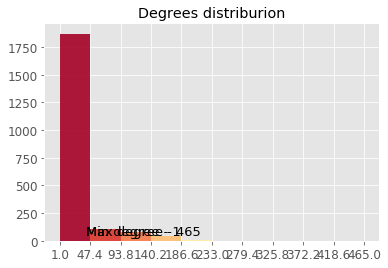

In [111]:
plt.title("Degrees distriburion", y = 1.00)
plot_hist(data = list(k.values()), colormap = 'RdYlBu', alpha = 0.9, bins = 10, round_value=1)
plt.text(x = 41, y = 52, s = "Max degree - " + str(max(k.values())), fontsize = 13)
plt.text(x = 41, y = 47, s = "Min degree - " + str(min(k.values())), fontsize = 13)

In [99]:
# take only giant connected component for the further analysis: 
largest_component = sorted(nx.connected_components(G_small), key = len, reverse=True)
print(len(largest_component))
Gc = G_small.subgraph(largest_component[0])
print("Number of nodes -", len(Gc.nodes()))
print("Number of edges -", len(Gc.edges()))

1
Number of nodes - 2113
Number of edges - 25767


In [123]:
k2 = {key: value for key, value in k.items() if value > 15 and value < 250}

G2 = G_small.subgraph(list(k2.keys()))
print("Number of nodes -", len(G2.nodes()))
print("Number of edges -", len(G2.edges()))

Number of nodes - 867
Number of edges - 18454


In [43]:




k3 = ['VK_9292673', 'VK_25232674', 'VK_27094302']


df = pd.read_csv('df_2370.csv', sep = '\t')
all_ids = list(df["ID"].unique())
df = df[df["Friends"].isin(all_ids)]
#G2 = G_small.subgraph(k3)
#G2.nodes()

In [45]:
df_2 = df.loc[df['ID'].isin(k3)]
df_2.sample(10)


,Unnamed: 0,Friends,ID,Name,_id
687105,687105,VK_80411754,VK_27094302,Анастасия Матвеенко,5e998fa2353564000819b166
687212,687212,VK_130864452,VK_27094302,Анастасия Матвеенко,5e998fa2353564000819b166
687254,687254,VK_145605995,VK_27094302,Анастасия Матвеенко,5e998fa2353564000819b166
686740,686740,VK_8154145,VK_27094302,Анастасия Матвеенко,5e998fa2353564000819b166
687331,687331,VK_191476986,VK_27094302,Анастасия Матвеенко,5e998fa2353564000819b166
687113,687113,VK_83582849,VK_27094302,Анастасия Матвеенко,5e998fa2353564000819b166
686833,686833,VK_19190015,VK_27094302,Анастасия Матвеенко,5e998fa2353564000819b166
687096,687096,VK_77941757,VK_27094302,Анастасия Матвеенко,5e998fa2353564000819b166
687348,687348,VK_211139111,VK_27094302,Анастасия Матвеенко,5e998fa2353564000819b166
677020,677020,VK_136673203,VK_25232674,Ян Дзюбинский,5e998fa0353564000819b162


In [44]:
subgraph_ids = list(df["Friends"].unique())
len(subgraph_ids)

2201

In [46]:
seed_frineds = set(df_2["ID"])
print(len(seed_frineds))
for myid in df_2["Friends"]:
    seed_frineds.add(myid)
print(len(seed_frineds))

3
210


In [48]:
G3 = G_small.subgraph(seed_frineds)
print("Number of nodes -", len(G3.nodes()))
print("Number of edges -", len(G3.edges()))

Number of nodes - 210
Number of edges - 8754


(-0.95, 1.05, -1.0, 0.75)

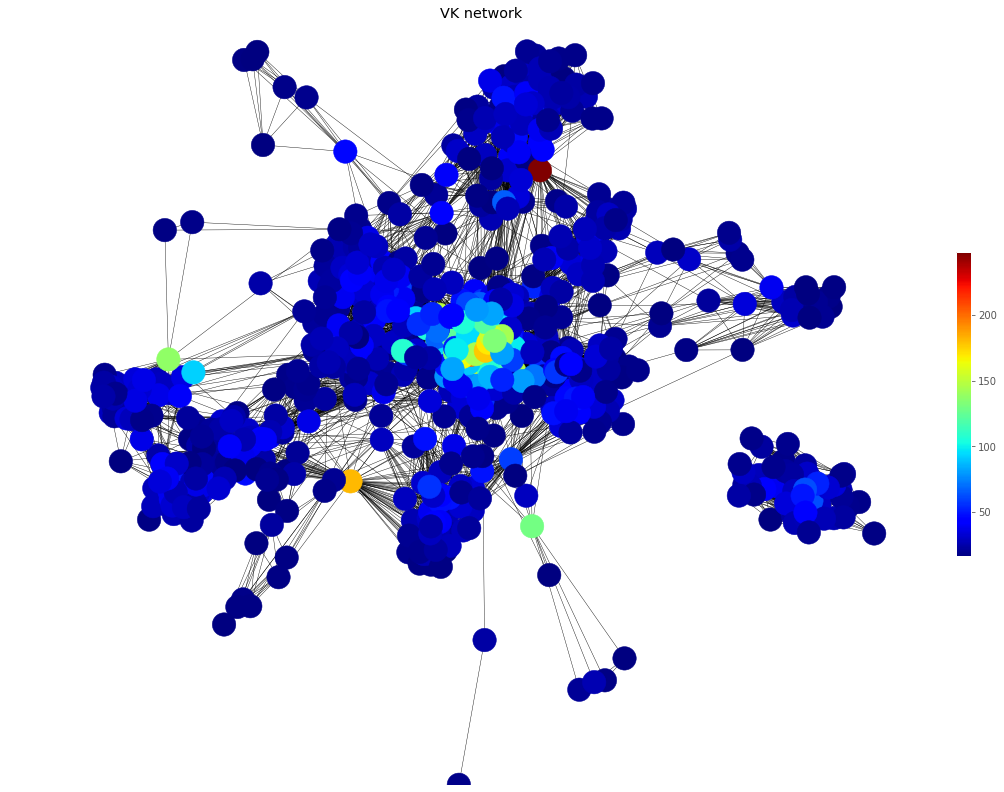

In [124]:
coord = nx.spring_layout(G2, k = 0.15)

plt.figure(figsize=(20,14))

node_colors = list(k2.values())

nodes = nx.draw_networkx_nodes(G2, pos = coord, 
                               node_color=node_colors, 
                               node_size = 550, 
                               nodelist=list(k2.keys()),                
                               with_labels = False,
                               cmap = 'jet')
edges = nx.draw_networkx_edges(G2, pos = coord, width = .4)

# the borders can be then reduced to zoom in the graph:
plt.xlim([-.95, 1.05])
plt.ylim([-1., .75])
# add colorbar to see which nodes have the highest degrees:
plt.colorbar(nodes, shrink = .4, pad = .0005, aspect = 20)
plt.title('VK network')
plt.axis("off")